# Real Estate Price Prediction Bengaluru Project

***

In [104]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

pd.reset_option('max_rows', 'max_columns')
sns.set_theme()
%matplotlib inline


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [20]:
df = pd.read_csv('/content/drive/MyDrive/Data_Science/Data/bengaluru_house_prices.csv')
df


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [21]:
df = df.drop_duplicates()
df.shape


(12791, 9)

In [22]:
df.isnull().sum()


area_type          0
availability       0
location           1
size              16
society         5328
total_sqft         0
bath              73
balcony          605
price              0
dtype: int64

In [23]:
df = df.drop(['area_type', 'availability', 'society', 'balcony'], axis = 'columns')
df.head()


,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [24]:
df.isnull().sum()


location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [25]:
df = df.dropna(axis = 'rows')
df.shape


(12717, 5)

In [26]:
df.dtypes


location       object
size           object
total_sqft     object
bath          float64
price         float64
dtype: object

## price

In [27]:
df['price'] = df['price'] * 100000


<ipython-input-27-01392932297b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'] * 100000


## size

In [28]:
df['size'].unique()


array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [29]:
df[['bhk', 'bhk_copy']] = df['size'].str.split(' ', expand = True)
df = df.drop(['size', 'bhk_copy'], axis = 1)
df['bhk'] = df['bhk'].astype('float')
df.head()


<ipython-input-29-244a81e1d79c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['bhk', 'bhk_copy']] = df['size'].str.split(' ', expand = True)
<ipython-input-29-244a81e1d79c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['bhk', 'bhk_copy']] = df['size'].str.split(' ', expand = True)


,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,3907000.0,2.0
1,Chikka Tirupathi,2600,5.0,12000000.0,4.0
2,Uttarahalli,1440,2.0,6200000.0,3.0
3,Lingadheeranahalli,1521,3.0,9500000.0,3.0
4,Kothanur,1200,2.0,5100000.0,2.0


## bhk

In [30]:
df['bhk'].describe()


count    12717.000000
mean         2.815994
std          1.312744
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         43.000000
Name: bhk, dtype: float64

In [31]:
df['bhk'].value_counts()


bhk
2.0     5244
3.0     4630
4.0     1376
1.0      631
5.0      347
6.0      221
7.0       99
8.0       89
9.0       54
10.0      14
11.0       4
27.0       1
19.0       1
16.0       1
43.0       1
14.0       1
12.0       1
13.0       1
18.0       1
Name: count, dtype: int64

In [32]:
df = df[df['bhk'] <= 10]
df['bhk'].unique()


array([ 2.,  4.,  3.,  6.,  1.,  8.,  7.,  5.,  9., 10.])

### total_sqft

In [33]:
df['total_sqft'].unique()


array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [34]:
def check_float(x):
    try:
        float(x)
        return np.NaN
    except:
        return x


In [35]:
df['total_sqft'].apply(check_float).unique()


array([nan, '2100 - 2850', '3067 - 8156', '1042 - 1105', '1145 - 1340',
       '1015 - 1540', '34.46Sq. Meter', '1195 - 1440', '4125Perch',
       '1120 - 1145', '3090 - 5002', '1160 - 1195', '1000Sq. Meter',
       '1115 - 1130', '1100Sq. Yards', '520 - 645', '1000 - 1285',
       '650 - 665', '633 - 666', '5.31Acres', '30Acres', '1445 - 1455',
       '884 - 1116', '850 - 1093', '716Sq. Meter', '547.34 - 827.31',
       '580 - 650', '3425 - 3435', '1804 - 2273', '3630 - 3800',
       '4000 - 5249', '1500Sq. Meter', '142.61Sq. Meter', '1574Sq. Yards',
       '1250 - 1305', '670 - 980', '1005.03 - 1252.49', '1004 - 1204',
       '361.33Sq. Yards', '645 - 936', '2710 - 3360', '2830 - 2882',
       '596 - 804', '1255 - 1863', '1300 - 1405', '117Sq. Yards',
       '934 - 1437', '980 - 1030', '2249.81 - 4112.19', '1070 - 1315',
       '3040Sq. Meter', '500Sq. Yards', '2806 - 3019', '613 - 648',
       '704 - 730', '1210 - 1477', '3369 - 3464', '1125 - 1500',
       '167Sq. Meter', '1076 - 1

In [36]:
def to_float(x):
    try:
        return float(x)
    except:
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        elif '-' not in x:
            return None


In [37]:
df['total_sqft'] = df['total_sqft'].apply(to_float)


In [38]:
df.isnull().sum()


location       0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [39]:
df = df.dropna(axis = 'rows')


In [43]:
df['total_sqft'].dtype


dtype('float64')

In [40]:
df['total_sqft'].describe()


count    12659.000000
mean      1563.014765
std       1254.429805
min          1.000000
25%       1100.000000
50%       1280.000000
75%       1685.000000
max      52272.000000
Name: total_sqft, dtype: float64

### location

In [44]:
df['location'].value_counts()


location
Whitefield                            515
Sarjapur  Road                        372
Electronic City                       287
Kanakpura Road                        240
Thanisandra                           227
                                     ... 
Rajanna Layout                          1
Lakshmipura Vidyaanyapura               1
Malur Hosur Road                        1
Kengeri Satellite Town ( BDA SITE)      1
Abshot Layout                           1
Name: count, Length: 1289, dtype: int64

In [45]:
locations = pd.DataFrame(df['location'].value_counts()).reset_index()
locations = locations.rename(columns = {'count': 'location_count'})
locations = locations[locations['location_count'] < 10]
locations


,location,location_count
249,Medahalli,9
250,Ejipura,9
251,Jakkur Plantation,9
252,Banagiri Nagar,9
253,Sector 1 HSR Layout,9
...,...,...
1284,Rajanna Layout,1
1285,Lakshmipura Vidyaanyapura,1
1286,Malur Hosur Road,1
1287,Kengeri Satellite Town ( BDA SITE),1


In [46]:
df['location'] = df['location'].apply(
    lambda x: 'Other' if x in list(locations['location']) else x
)
df['location'].value_counts()


location
Other                   2755
Whitefield               515
Sarjapur  Road           372
Electronic City          287
Kanakpura Road           240
                        ... 
Narayanapura              10
BTM 1st Stage             10
Nagappa Reddy Layout      10
Naganathapura             10
Nagadevanahalli           10
Name: count, Length: 250, dtype: int64

# Outliers

## price & total_sqft

In [47]:
df['price'].describe()


count    1.265900e+04
mean     1.138517e+07
std      1.515860e+07
min      8.000000e+05
25%      5.000000e+06
50%      7.260000e+06
75%      1.200000e+07
max      3.600000e+08
Name: price, dtype: float64

In [48]:
df['total_sqft'].describe()


count    12659.000000
mean      1563.014765
std       1254.429805
min          1.000000
25%       1100.000000
50%       1280.000000
75%       1685.000000
max      52272.000000
Name: total_sqft, dtype: float64

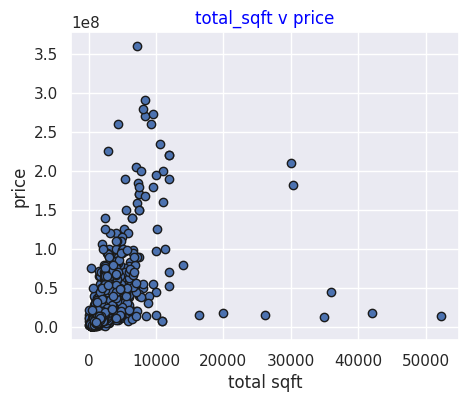

In [67]:
plt.figure(figsize = (5,4))
plt.scatter(df['total_sqft'], df['price'], edgecolor = 'k')
plt.xlabel('total sqft')
plt.ylabel('price')
plt.title('Total Sqft v Price', color = 'blue')
plt.show()


In [68]:
df['price_per_sqft'] = df['price'] / df['total_sqft']
df['price_per_sqft'].describe()


count    1.265900e+04
mean     8.033790e+03
std      1.089811e+05
min      2.678298e+02
25%      4.298610e+03
50%      5.483631e+03
75%      7.400532e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [ ]:
df = df[np.logical_and(df['price_per_sqft'] > 4000, df['price_per_sqft'] < 7000)]


In [70]:
df.shape


(6641, 6)

In [71]:
df['total_sqft'].max()


30400.0

In [73]:
# try using linear regression with only total_sqft feature after removing outliers

X = df[['total_sqft']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
test_model = LinearRegression().fit(X_train, y_train)
test_model.score(X_train, y_train), test_model.score(X_test, y_test)


(0.9261244552746005, 0.8975760099797575)

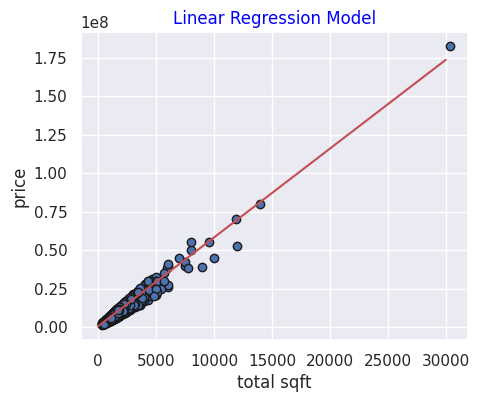

In [76]:
k = np.linspace(0, 30000, 1000)
z = test_model.coef_ * k - test_model.intercept_

plt.figure(figsize = (5,4))
plt.scatter(df['total_sqft'], df['price'], edgecolor = 'k')
plt.plot(k, z, color = 'r')
plt.xlabel('total sqft')
plt.ylabel('price')
plt.title('Linear Regression Model', color = 'blue')
plt.show()


## sqft_per_bhk

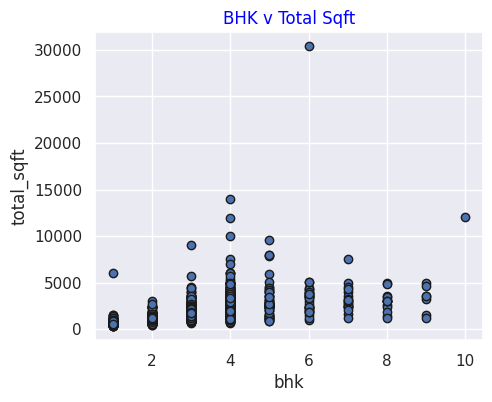

In [78]:
plt.figure(figsize = (5,4))
plt.scatter(df['bhk'], df['total_sqft'], edgecolor = 'k')
plt.xlabel('bhk')
plt.ylabel('total_sqft')
plt.title('BHK v Total Sqft', color = 'blue')
plt.show()


In [79]:
df['sqft_per_bhk'] = df['total_sqft'] / df['bhk']
df['sqft_per_bhk'].describe()


count    6641.000000
mean      570.410616
std       171.205012
min       130.888889
25%       497.500000
50%       556.500000
75%       617.500000
max      6000.000000
Name: sqft_per_bhk, dtype: float64

In [80]:
df = df[np.logical_and(df['sqft_per_bhk'] > 200, df['sqft_per_bhk'] < 1000)]


In [81]:
df.shape


(6528, 7)

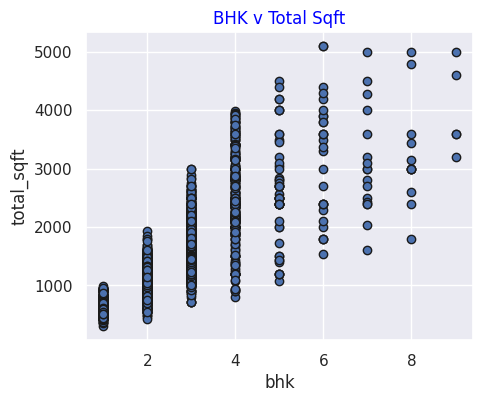

In [82]:
# visualize bhk v total_sqft after removing outliers

plt.figure(figsize = (5,4))
plt.scatter(df['bhk'], df['total_sqft'], edgecolor = 'k')
plt.xlabel('bhk')
plt.ylabel('total_sqft')
plt.title('BHK v Total Sqft', color = 'blue')
plt.show()


### bath & bhk

In [83]:
df['bath_bhk'] = df['bath'] - df['bhk']


In [84]:
len(df[df['bath_bhk'] > 1])


36

In [85]:
df = df[df['bath_bhk'] <= 1]


In [87]:
df.head()


,location,total_sqft,bath,price,bhk,price_per_sqft,sqft_per_bhk,bath_bhk
1,Chikka Tirupathi,2600.0,5.0,12000000.0,4.0,4615.384615,650.000000,1.0
2,Uttarahalli,1440.0,2.0,6200000.0,3.0,4305.555556,480.000000,-1.0
3,Lingadheeranahalli,1521.0,3.0,9500000.0,3.0,6245.890861,507.000000,0.0
4,Kothanur,1200.0,2.0,5100000.0,2.0,4250.000000,600.000000,0.0
8,Marathahalli,1310.0,3.0,6325000.0,3.0,4828.244275,436.666667,0.0


In [88]:
df = df.drop(columns = ['sqft_per_bhk', 'price_per_sqft', 'bath_bhk'])


In [89]:
df


,location,total_sqft,bath,price,bhk
1,Chikka Tirupathi,2600.0,5.0,12000000.0,4.0
2,Uttarahalli,1440.0,2.0,6200000.0,3.0
3,Lingadheeranahalli,1521.0,3.0,9500000.0,3.0
4,Kothanur,1200.0,2.0,5100000.0,2.0
8,Marathahalli,1310.0,3.0,6325000.0,3.0
...,...,...,...,...,...
13309,Yeshwanthpur,1675.0,3.0,9213000.0,3.0
13310,Rachenahalli,1050.0,2.0,5271000.0,2.0
13314,Green Glen Layout,1715.0,3.0,11200000.0,3.0
13315,Whitefield,3453.0,4.0,23100000.0,5.0


## location (One Hot Encoding)

In [90]:
loc_dummies = pd.get_dummies(df.location)
loc_dummies.head()


,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [91]:
loc_dummies = loc_dummies.drop('Other', axis = 'columns')
loc_dummies.head()


,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [92]:
df = pd.concat([df, loc_dummies], axis = 'columns')
df.head()


,location,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,Chikka Tirupathi,2600.0,5.0,12000000.0,4.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Uttarahalli,1440.0,2.0,6200000.0,3.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Lingadheeranahalli,1521.0,3.0,9500000.0,3.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Kothanur,1200.0,2.0,5100000.0,2.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,Marathahalli,1310.0,3.0,6325000.0,3.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [93]:
df = df.drop('location', axis = 'columns')
df.head()


,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,2600.0,5.0,12000000.0,4.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1440.0,2.0,6200000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1521.0,3.0,9500000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1200.0,2.0,5100000.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,1310.0,3.0,6325000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [98]:
df = df.reset_index(drop = True)
df


,total_sqft,bath,price,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2600.0,5.0,12000000.0,4.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1440.0,2.0,6200000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1521.0,3.0,9500000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,5100000.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1310.0,3.0,6325000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6487,1675.0,3.0,9213000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6488,1050.0,2.0,5271000.0,2.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6489,1715.0,3.0,11200000.0,3.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6490,3453.0,4.0,23100000.0,5.0,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


# Model Building

In [99]:
X = df.drop(columns = ['price'])
X


,total_sqft,bath,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2600.0,5.0,4.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1440.0,2.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1521.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1310.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6487,1675.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6488,1050.0,2.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6489,1715.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6490,3453.0,4.0,5.0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [100]:
y = df['price']
y


0       12000000.0
1        6200000.0
2        9500000.0
3        5100000.0
4        6325000.0
           ...    
6487     9213000.0
6488     5271000.0
6489    11200000.0
6490    23100000.0
6491     6000000.0
Name: price, Length: 6492, dtype: float64

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)


In [102]:
X_train


,total_sqft,bath,bhk,Devarachikkanahalli,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
2738,1440.0,4.0,4.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1715,1460.0,2.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5249,2100.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5309,1250.0,2.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
188,1000.0,2.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699,1718.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2550,1486.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
537,1100.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1220,1220.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [103]:
y_train


2738     8800000.0
1715     7300000.0
5249    12500000.0
5309     6200000.0
188      6700000.0
           ...    
5699     9020000.0
2550     8322000.0
537      5300000.0
1220     5600000.0
4271     7500000.0
Name: price, Length: 5193, dtype: float64

In [105]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 7)


## LinearRegression

In [106]:
linear_reg_model = LinearRegression().fit(X_train, y_train)
linear_reg_model.score(X_train, y_train), linear_reg_model.score(X_test, y_test)


(0.8856698375498739, 0.8612659863569714)

In [107]:
cross_val_score(LinearRegression(), X, y, cv = cv)


array([0.86126599, 0.88150525, 0.8736491 , 0.84369509, 0.87898502])

## XGBRegressor

In [108]:
xgboost_model = XGBRegressor().fit(X_train, y_train)
xgboost_model.score(X_train, y_train), xgboost_model.score(X_test, y_test)


(0.9248894982596321, 0.8597593880896082)

In [109]:
cross_val_score(XGBRegressor(), X, y, cv = cv)


array([0.85975939, 0.88210825, 0.88571425, 0.84227666, 0.88502554])

## Lasso

In [110]:
lasso_model = Lasso().fit(X_train, y_train)
lasso_model.score(X_train, y_train), lasso_model.score(X_test, y_test)


(0.885669813700728, 0.8612769167412465)

In [111]:
cross_val_score(Lasso(), X, y, cv = cv)


array([0.86127692, 0.88151214, 0.87365711, 0.84369798, 0.87899583])

## DecisionTreeRegressor

In [112]:
decision_tree_model = DecisionTreeRegressor().fit(X_train, y_train)
decision_tree_model.score(X_train, y_train), decision_tree_model.score(X_test, y_test)


(0.9861472058928629, 0.7991655952543565)

In [113]:
cross_val_score(DecisionTreeRegressor(), X, y, cv = cv)


array([0.80568255, 0.82562862, 0.84296634, 0.75924439, 0.8175319 ])

## RandomForestRegressor

In [114]:
random_forest_model = RandomForestRegressor().fit(X_train, y_train)
random_forest_model.score(X_train, y_train), random_forest_model.score(X_test, y_test)


(0.9711582385755683, 0.8567435133903192)

In [115]:
cross_val_score(RandomForestRegressor(), X, y, cv = cv)


array([0.8545316 , 0.87916004, 0.87677477, 0.8342051 , 0.87364982])

# Choosing Best Model

In [116]:
pd.DataFrame(
    {
        'train|test':           ['train', 'test'],
        'Linear Regression':    [linear_reg_model.score(X_train, y_train), linear_reg_model.score(X_test, y_test)],
        'XGBoost':              [xgboost_model.score(X_train, y_train), xgboost_model.score(X_test, y_test)],
        'Lasso':                [lasso_model.score(X_train, y_train), lasso_model.score(X_test, y_test)],
        'Decision Tree':        [decision_tree_model.score(X_train, y_train), decision_tree_model.score(X_test, y_test)],
        'Random Forest':        [random_forest_model.score(X_train, y_train), random_forest_model.score(X_test, y_test)]
    }
)


,train|test,Linear Regression,XGBoost,Lasso,Decision Tree,Random Forest
0,train,0.885670,0.924889,0.885670,0.986147,0.971158
1,test,0.861266,0.859759,0.861277,0.799166,0.856744


In [ ]:
# choosing Linear Regression Model

import pickle
with open('Real_Estate_Price_Prediction_Bengaluru_Project.pickle','wb') as f:
    pickle.dump(linear_reg_model, f)


***

**End of Project**